In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from circle_fit import taubinSVD
from hyperopt import fmin, tpe, hp, Trials

In [2]:
def rho_approx(zeta, l, phi, theta):
    if np.abs(theta - np.pi / 2) < 0.5:
            return phi - (1 - 120 * zeta**2 + 720 * zeta**4) * (theta - np.pi / 2)**3 / 360 / l - (12 * zeta**2 - 1) * (theta - np.pi / 2) / 6 / l

    return (phi * l - (2 * theta - np.pi) / 4 / np.cos(theta)**2 + np.sign(2 * theta - np.pi) * np.sqrt(1 / np.cos(theta)**2 - 4 * zeta**2) + np.tan(theta) / 2) / l

In [3]:
def data_cutting(z, dens, offset):
    new_z, new_dens = [], []
    for i, zi in enumerate(z):
        if np.abs(zi) <= 0.5 - offset:
            new_z.append(zi)
            new_dens.append(dens[i])

    return np.array(new_z), np.array(new_dens)

In [4]:
def dens_norm(z, dens, angle):
    dens /= np.trapz(dens, z)
    dens *= np.trapz(rho_approx(z, 2.5, 0.5, angle), z)

    return dens

(0.0, 1.0)

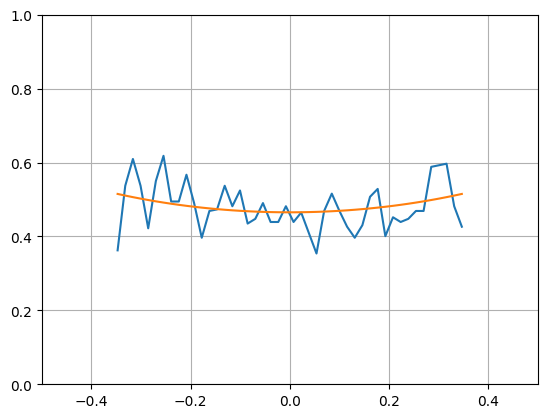

In [6]:
angle = 60
H = 3.928
z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
z /= H
offset = 0.15

z, dens = data_cutting(z, dens, offset)
dens = dens_norm(z, dens, np.deg2rad(angle))

plt.grid()
plt.plot(z, dens)
plt.plot(z, rho_approx(z, 2.5, 0.5, np.deg2rad(angle)))
plt.xlim(-0.5, 0.5)
plt.ylim(0, 1)

In [39]:
angle = 60
H = 3.928
offset = 0.125

def objective(args):
    z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
    z /= H

    z, dens = data_cutting(z, dens, offset)
    dens = dens_norm(z, dens, args['theta'])

    # return np.sum((rho_approx(z, 2.5, 0.5, args['theta']) - dens)**2)
    return np.sum(np.abs(rho_approx(z, 2.5, 0.5, args['theta']) - dens))

In [48]:
def fit():
    trials = Trials()
    space = {
        'theta': hp.uniform('theta', 0, np.pi)
    }

    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=500,
        trials=trials,
        show_progressbar=False
    )

    return best

In [55]:
real = []
approx = []
for offset in [0.13]:
    print('offset:', offset)
    print('real\tapprox')
    for angle in range(15, 166, 15):
        H = 3.928
        # offset = 0.125

        def objective(args):
            z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
            z /= H

            z, dens = data_cutting(z, dens, offset)
            dens = dens_norm(z, dens, args['theta'])

            return np.sum((rho_approx(z, 2.5, 0.5, args['theta']) - dens)**2)

        best = fit()
        print(str(angle)+'\t'+'{:.1f}'.format(np.rad2deg(best['theta'])))
        real.append(angle)
        approx.append(np.rad2deg(best['theta']))
    print()

offset: 0.13
real	approx
15	43.9
30	59.9
45	38.7
60	61.3
75	89.5
90	83.6
105	105.6
120	114.3
135	155.7
150	162.2
165	171.1



In [56]:
real = np.array(real)
approx = np.array(approx)

In [58]:
i = 5
np.mean(np.abs(real[i:] - approx[i:]) / real[i:] * 100)

6.605585231236273

(0.0, 1.0)

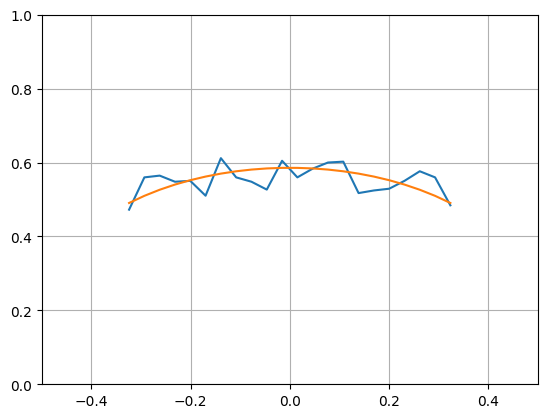

In [52]:
angle = 165
H = 3.928
z, dens = np.loadtxt(f"na_diff/angles/density/density_{angle}.xvg", comments=["@", "#"], unpack=True)
z /= H
offset = 0.15

z, dens = data_cutting(z, dens, offset)
dens = dens_norm(z, dens, best['theta'])

plt.grid()
plt.plot(z, dens)
plt.plot(z, rho_approx(z, 2.5, 0.5, best['theta']))
plt.xlim(-0.5, 0.5)
plt.ylim(0, 1)